# Performance Analysis
## joint vs. baseline QASRL/QANom models

In [ ]:
import json 
import pandas as pd
import numpy as np
import torch
import itertools
from collections import defaultdict, Counter
%matplotlib inline
import matplotlib.pyplot as plt

import datasets
import qanom
from qanom.annotations.common import read_annot_csv

# Helper functions
def report_overlap(**kwargs):
    assert len(kwargs)==2
    (nm1, s1), (nm2, s2) = tuple(kwargs.items())
    s1, s2 = set(s1), set(s2)
    print(f"|{nm1}|={len(s1)}, |{nm2}|={len(s2)};   Union: {len(s1|s2)}  Intersection: {len(s1&s2)} ")
    print(f"|{nm1}-{nm2}|={len(s1-s2)}, |{nm2}-{nm1}|={len(s2-s1)};   ")

def plot_counter_as_pie_chart(counter, title=None):
    items = list(counter.items())
    items = sorted(items, key=lambda kv: kv[0]) # sort by key
    labels, sizes = zip(*items)

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={"color":"orange"})
    if title:
        fig1.suptitle(title, fontsize=14, color="orange")
    

def set_key_column(df, sent_id_lbl, pred_idx_lbl):
    df['key'] = df.apply(lambda r: f"{r[sent_id_lbl]}_{r[pred_idx_lbl]}", axis=1)



### Preperations 
Load datasets and predictions

In [2]:
# Predictions
joint_qanom_predictions_fn = "../trained_models/t5_qanom-joint-23.03.22/generated_predictions.csv"
baseline_qanom_predictions_fn = "../trained_models/t5_30ep-qanom-baseline-13.03.22/generated_predictions.csv"
joint_qanom_predictions_df = pd.read_csv(joint_qanom_predictions_fn)
baseline_qanom_predictions_df = pd.read_csv(baseline_qanom_predictions_fn)


In [4]:
# Datasets
qanom_dataset = datasets.load_dataset("biu-nlp/qanom")
# qasrl_dataset = datasets.load_dataset("kleinay/qa_srl")

qanom_test_df = qanom_dataset['test'].to_pandas()
qanom_dev_df = qanom_dataset['validation'].to_pandas()
qanom_train_df = qanom_dataset['train'].to_pandas()

for df in (qanom_test_df, qanom_dev_df, qanom_train_df):
    set_key_column(df, 'sent_id', 'predicate_idx')

No config specified, defaulting to: qanom/default
Reusing dataset qanom (/home/nlp/kleinay/.cache/huggingface/datasets/biu-nlp___qanom/default/1.1.0/44d54349c6d3f70e326208bf63485003c5410d38a6aae87eb80d74cf887627d0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
qadisc_dataset = datasets.load_dataset("biu-nlp/qa_discourse") 

### Num-answer distribution


In [6]:
for split in ('train', 'validation', 'test'):
    df = qasrl_dataset[split].to_pandas()
    set_key_column(df, 'sent_id', 'predicate_idx')
    print("sentences: ", df.sent_id.nunique())
    print("predicates: ", df.key.nunique())
    

sentences:  44476
predicates:  95253
sentences:  1000
predicates:  1000
sentences:  999
predicates:  999


In [44]:
for split in ('train', 'validation', 'test'):
    print("\n", split)
    df = qadisc_dataset[split].to_pandas()#.sentence.nunique()
    print("sentences:", df.sent_id.nunique())
    print("sentences with no QAs:", df.question.str.len().value_counts()[0])
    print("QAs:", df.answers.str.len().sum())
    



 train
sentences: 7994
sentences with no QAs: 1655
QAs: 10985

 validation
sentences: 1834
sentences with no QAs: 498
QAs: 2632

 test
sentences: 1779
sentences with no QAs: 443
QAs: 2996


In [ ]:
d=qanom_dataset['test']
d['answers']

In [24]:
# qasrl_dataset['train'][0]

d=qanom_dataset['train']
df=d.to_pandas()
print(df.shape)
# df = df[df['question'].str.len()!=0]
# print(df.shape)
df.groupby(['sent_id', 'predicate'])['question'].count().value_counts()
# n_answers = [len(d) for d in qasrl_dataset['train']['answers']]
# Counter(n_answers)

(29705, 9)


1    15189
2     3742
3     1501
4      452
5      109
6       12
7        9
8        4
9        1
Name: question, dtype: int64

## Anaylze by lexical overlap 


In [6]:

def get_verb_form_set(data):
    return set(data['verb_form'])

nom_train_vrbs = get_verb_form_set(qanom_dataset['train'])
nom_dev_vrbs = get_verb_form_set(qanom_dataset['validation'])
report_overlap(nom_train_vrbs=nom_train_vrbs, nom_dev_vrbs=nom_dev_vrbs )
vrb_train_vrbs = get_verb_form_set(qasrl_dataset['train'])
vrb_dev_vrbs = get_verb_form_set(qasrl_dataset['validation'])
report_overlap(vrb_train_vrbs=vrb_train_vrbs, vrb_dev_vrbs=vrb_dev_vrbs )
joint_train_vrbs = nom_train_vrbs | vrb_train_vrbs
report_overlap(joint_train_vrbs=joint_train_vrbs, nom_dev_vrbs=nom_dev_vrbs)


|nom_train_vrbs|=1569, |nom_dev_vrbs|=880;   Union: 1728  Intersection: 721 
|nom_train_vrbs-nom_dev_vrbs|=848, |nom_dev_vrbs-nom_train_vrbs|=159;   
|vrb_train_vrbs|=3039, |vrb_dev_vrbs|=468;   Union: 3053  Intersection: 454 
|vrb_train_vrbs-vrb_dev_vrbs|=2585, |vrb_dev_vrbs-vrb_train_vrbs|=14;   
|joint_train_vrbs|=3384, |nom_dev_vrbs|=880;   Union: 3451  Intersection: 813 
|joint_train_vrbs-nom_dev_vrbs|=2571, |nom_dev_vrbs-joint_train_vrbs|=67;   


In [3]:
qanom_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sent_id', 'predicate_idx', 'predicate', 'is_verbal', 'verb_form', 'question', 'answers', 'answer_ranges'],
        num_rows: 29705
    })
    validation: Dataset({
        features: ['sentence', 'sent_id', 'predicate_idx', 'predicate', 'is_verbal', 'verb_form', 'question', 'answers', 'answer_ranges'],
        num_rows: 7502
    })
    test: Dataset({
        features: ['sentence', 'sent_id', 'predicate_idx', 'predicate', 'is_verbal', 'verb_form', 'question', 'answers', 'answer_ranges'],
        num_rows: 6937
    })
})

## Output Role Distribution

Counter({'what': 1611, 'who': 1220, 'how': 673, 'where': 540, 'when': 410, 'why': 366, 'how much': 30, 'how long': 27})


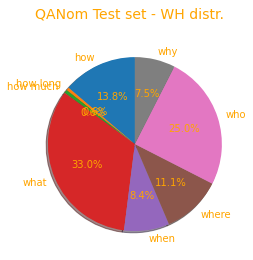

In [29]:
## for simplicity - by WH word
qanom_questions = qanom_dataset['test']['question'] 
qanom_wh_words = [q[0] for q in qanom_questions if q]
qanom_wh_dist = Counter(qanom_wh_words)
print(qanom_wh_dist)
plot_counter_as_pie_chart(qanom_wh_dist, "QANom Test set - WH distr.")

In [ ]:
qasrl_questions = qasrl_dataset['validation']['question'] 
qasrl_wh_words = [q[0] for q in qasrl_questions if q]
qasrl_wh_dist = Counter(qasrl_wh_words)
print(qasrl_wh_dist)
plot_counter_as_pie_chart(qasrl_wh_dist)

In [ ]:
predicted_qanom_by_joint_fn = "joint_on_qanom_generated_predictions.csv"
predicted_qanom_by_joint_df = pd.read_csv(predicted_qanom_by_joint_fn)
predicted_qanom_by_joint_df['key'] = predicted_qanom_by_joint_df.apply(lambda r: f"{r['qasrl_id']}_{r['verb_idx']}", axis=1)
predicted_qanom_wh_words = predicted_qanom_by_joint_df.question.apply(lambda s: s.split()[0]).tolist()
predicted_qanom_wh_dist = Counter(predicted_qanom_wh_words)
print(predicted_qanom_wh_dist)
plot_counter_as_pie_chart(predicted_qanom_wh_dist)

## QA Redundancy
Investigate whether the best model (joint) is producing redundant QAs - how many times it produces the same answer twich or the same question twice 

In [17]:
# count duplicate QAs
# By Question
n_qs = predicted_qanom_by_joint_df[['key', 'question']].shape[0]
n_unique_qs = predicted_qanom_by_joint_df[['key', 'question']].drop_duplicates().shape[0]
n_redund_qa = n_qs - n_unique_qs 
print(f"Out of {n_qs} questions, {n_redund_qa} ({100*n_redund_qa/n_qs:.01f}%) are repeated")
# By Answer
n_as = predicted_qanom_by_joint_df[['key', 'answer']].shape[0]
n_unique_as = predicted_qanom_by_joint_df[['key', 'answer']].drop_duplicates().shape[0]
n_redund_ans = n_as - n_unique_as 
print(f"Out of {n_as} answers, {n_redund_ans} ({100*n_redund_ans/n_as:.01f}%) are repeated")
# By QA
n_as = predicted_qanom_by_joint_df[['key', 'question', 'answer']].shape[0]
n_unique_as = predicted_qanom_by_joint_df[['key', 'question', 'answer']].drop_duplicates().shape[0]
n_redund_ans = n_as - n_unique_as 
print(f"Out of {n_as} QAs, {n_redund_ans} ({100*n_redund_ans/n_as:.01f}%) are repeated")


Out of 5221 questions, 106 (2.0%) are repeated
Out of 5221 answers, 6 (0.1%) are repeated
Out of 5221 QAs, 4 (0.1%) are repeated


In [24]:
dupl_qs_df = predicted_qanom_by_joint_df[predicted_qanom_by_joint_df.duplicated(['key', 'question'], keep=False)]
dupl_qs_df.to_csv("duplicated_questions.csv")

## Performance per #-QAs (output seq length)
does the model fails more in longer sequences (more QAs / longer answers)? 

does permutation sampling by |qas| mitigate this? 


Note: the prediction files are on test set.

In [ ]:
gold_mean_num_qas = qanom_train_df.groupby('key').key.count().mean()
print(f"mean num of QAs at gold (all train set): {gold_mean_num_qas}")
gold_mean_num_qas = qanom_dev_df.groupby('key').key.count().mean()
print(f"mean num of QAs at gold (all dev set): {gold_mean_num_qas}")
gold_mean_num_qas = qanom_test_df.groupby('key').key.count().mean()
print(f"mean num of QAs at gold (all test set): {gold_mean_num_qas}")
predictions_df = pd.read_csv("/home/nlp/kleinay/tmp/t5-tst-summarization/qanom/qanom/linearization/all_by_answer_ordering/generated_predictions.csv")


Base Dir: /home/nlp/kleinay/tmp/t5-tst-summarization/qanom/qanom/linearization *** 


 permutate_sample_num_of_qas model:
mean num of QAs at prediction (all test set): 2.1895509499136443
mean num of QAs at gold (all test set): 1.582344890510949
mean num of QAs (in gold) for predicates that had a False-Negative : 2.409340659340659
mean num of QAs (in predictions) for predicates that had a False-Positive : 2.35014409221902

 all_by_answer_ordering model:
mean num of QAs at prediction (all test set): 1.9540727902946273
mean num of QAs at gold (all test set): 1.582344890510949
mean num of QAs (in gold) for predicates that had a False-Negative : 2.3823529411764706
mean num of QAs (in predictions) for predicates that had a False-Positive : 2.2397558849171753


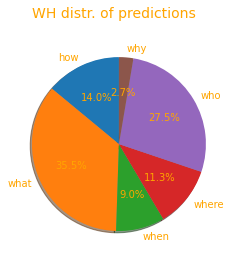

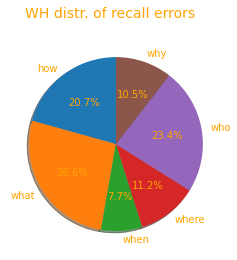

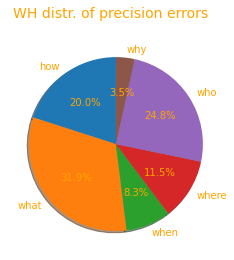

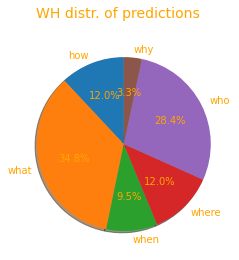

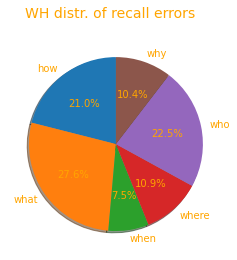

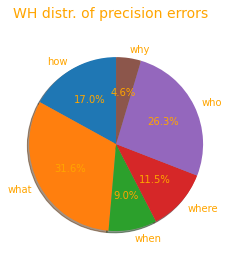

In [30]:

# measure mean #-QAs in predicted outputs
def anaylze_predictions(out_dir):
    
    predictions_fn = f"{out_dir}/generated_predictions.csv"
    predictions_df = pd.read_csv(predictions_fn)
    set_key_column(predictions_df, 'qasrl_id', 'verb_idx')
    mean_num_qas = predictions_df.groupby('key').key.count().mean()
    print(f"mean num of QAs at prediction (all test set): {mean_num_qas}")
    gold_mean_num_qas = qanom_test_df.groupby('key').key.count().mean()
    print(f"mean num of QAs at gold (all test set): {gold_mean_num_qas}")
    
    recall_errs_df = pd.read_csv(f"{out_dir}/recall_errors.csv")
    precision_errs_df = pd.read_csv(f"{out_dir}/precision_errors.csv")
    instances_with_fn = recall_errs_df.key.drop_duplicates().tolist()
    gold_instances_with_fn = qanom_test_df[qanom_test_df.key.isin(instances_with_fn)]
    mean_num_qas_at_fn = gold_instances_with_fn.groupby('key').key.count().mean()
    print(f"mean num of QAs (in gold) for predicates that had a False-Negative : {mean_num_qas_at_fn}")
    instances_with_fp = precision_errs_df.key.drop_duplicates().tolist()
    sys_instances_with_fn = predictions_df[predictions_df.key.isin(instances_with_fp)]
    mean_num_qas_at_fp = sys_instances_with_fn.groupby('key').key.count().mean()
    print(f"mean num of QAs (in predictions) for predicates that had a False-Positive : {mean_num_qas_at_fp}")
    # Plot Disribution of Wh-word of mistakes
    whs_predictions = predictions_df.question.str.split().str.get(0)
    plot_counter_as_pie_chart(Counter(whs_predictions), "WH distr. of predictions") 
    whs_recall_errs = recall_errs_df.question.str.split().str.get(0)
    plot_counter_as_pie_chart(Counter(whs_recall_errs), "WH distr. of recall errors") 
    whs_precision_errs = precision_errs_df.question.str.split().str.get(0)
    plot_counter_as_pie_chart(Counter(whs_precision_errs), "WH distr. of precision errors") 
    
    
base_dir = "/home/nlp/kleinay/tmp/t5-tst-summarization/qanom/qanom/linearization"
# base_dir = "/home/nlp/kleinay/tmp/t5-tst-summarization/joint_qanom/linearization"
print(f"Base Dir: {base_dir} *** \n")
for lin in ("permutate_sample_num_of_qas", "all_by_answer_ordering"):
    output_dir = f"{base_dir}/{lin}"
    print(f"\n {lin} model:")
    anaylze_predictions(output_dir)

In [18]:
Counter(predictions_df.question.str.split().str.get(0))

Counter({'what': 1569,
         'where': 543,
         'when': 428,
         'who': 1280,
         'why': 150,
         'how': 540})